   # <center> This notebook will walk you through how to perform importance sampling using X-PSI


```markdown
# Performing Importance Sampling with X-PSI

Importance sampling (calculating new posterior distribution based on the already existing samples) can be performed using X-PSI under the following circumstances:

1. # Model Update:  
   - The model itself has changed, which implies a modification of the likelihood function.
   - However, note that the importance sampling results become less accurate for larger likelihood changes.

2. # Change in Parameter Priors:  
   - The prior for one or more parameters has been modified.  
   - However, the new priors must still lie within the hypervolume of the original prior distribution, and the original sampling needs to have produced enough samples around the likeliest region of the new prior.

3. # Both Changes:  
   - Both the prior and the model have been updated simultaneously.
```

# <center>  1. Model Update

### For the new model, we changed the spin frequency from 314.0 Hz (which was used to generate the data) to 310.0 Hz (this is technically not the correct model, it's just an example). One reason to adjust only the frequency in the model while keeping the data unchanged could arise from inadvertently using a frequency different from the one used to fold the data, only to realize this discrepancy after performing the run (with the wrong frequency).

In [1]:
import math
import xpsi
from xpsi.Sample import importance
from xpsi.global_imports import gravradius

from collections import OrderedDict

/=============================================\
| X-PSI: X-ray Pulse Simulation and Inference |
|---------------------------------------------|
|               Version: 2.3.0-b              |
|---------------------------------------------|
|      https://xpsi-group.github.io/xpsi      |
\=============================================/

Check your emcee installation.
Check your installation of emcee if using the EnsembleSampler
Check your PyMultiNest installation.
Check your installation of PyMultiNest if using the NestedSampler
Check your UltraNest installation.
Check your installation of UltraNest if using the UltranestSampler
Imported GetDist version: 1.5.3
Imported nestcheck version: 0.2.1


In [2]:
%%capture
# Let's import the old and the new models
from Modules import main as old_model               # The spin in main is 314.0 Hz
from Modules import main_IS_likelihood as new_model # The spin in main_IS_likelihood is 310.0 Hz

In [3]:
def derive_names(model):
    out = str(model.likelihood)
    outA = out.split('\n')
    outA = outA[2:-1]
    names = []
    for i in range(len(outA)):
        a = outA[i]
        ind_end = a.find(':')
        if a[:ind_end].find(' ')<0:
            names.append(a[:ind_end])
    return names

names = derive_names(old_model)

In [4]:
names

['mass',
 'radius',
 'distance',
 'cos_inclination',
 'p__phase_shift',
 'p__super_colatitude',
 'p__super_radius',
 'p__super_temperature']

In [5]:
# Doing importance sampling

# Commenting this as it takes a bit of time to run
######################
# importance(new_model.likelihood,
#                   old_model.likelihood,
#                   'Outputs/ST_live_1000_eff_0.3_seed42',
#                   names = names,
#                   likelihood_change = True,
#                   prior_change = False,
#                   weight_threshold=1.0e-30,
#                   overwrite=True)

### Running the cell above will generate a file called, ST_live_1000_eff_0.3_seed42__importance_sampled_likelihood_change.txt
### that contains the new posteriors

### Now let's plot what the new posteriors look like compared to the old ones

In [6]:
# Getdist settings
getdist_kde_settings = {'ignore_rows': 0,
                         'min_weight_ratio': 1.0e-10,
                         'contours': [0.683, 0.954, 0.997],
                         'credible_interval_threshold': 0.001,
                         'range_ND_contour': 0,
                         'range_confidence': 0.001,
                         'fine_bins': 1024,
                         'smooth_scale_1D': 0.4,
                         'num_bins': 100,
                         'boundary_correction_order': 1,
                         'mult_bias_correction_order': 1,
                         'smooth_scale_2D': 0.4,
                         'max_corr_2D': 0.99,
                         'fine_bins_2D': 512,
                         'num_bins_2D': 40}

In [7]:
# Settings names, bounds and labels
old_model.names=['mass','radius','distance','cos_inclination','p__phase_shift',
          'p__super_colatitude','p__super_radius','p__super_temperature']

# We will use the same bounds used during sampling
old_model.bounds = {'mass':(1.0,1.6),
             'radius':(10,13),
             'distance':(0.5,2.0),
             'cos_inclination':(0,1),
             'p__phase_shift':(-0.25, 0.75),
             'p__super_colatitude':(0.001, math.pi/2 - 0.001),
             'p__super_radius':(0.001, math.pi/2.0 - 0.001),
             'p__super_temperature':(6., 7.)}

# Now the labels
old_model.labels = {'mass': r"M\;\mathrm{[M}_{\odot}\mathrm{]}",
              'radius': r"R_{\mathrm{eq}}\;\mathrm{[km]}",
              'distance': r"D \;\mathrm{[kpc]}",
              'cos_inclination': r"\cos(i)",
              'p__phase_shift': r"\phi_{p}\;\mathrm{[cycles]}",
              'p__super_colatitude': r"\Theta_{spot}\;\mathrm{[rad]}",
              'p__super_radius': r"\zeta_{spot}\;\mathrm{[rad]}",
              'p__super_temperature': r"\mathrm{log10}(T_{spot}\;[\mathrm{K}])"}

old_model.names +=['compactness']
old_model.bounds['compactness']=(gravradius(1.0)/16.0, 1.0/3.0)
old_model.labels['compactness']= r"M/R_{\mathrm{eq}}"



In [8]:
new_model.names = old_model.names
new_model.bounds = old_model.bounds
new_model.labels = old_model.labels

In [9]:
# Loading old run
old_model.runs = xpsi.Runs.load_runs(ID='Old likelihood',
                               run_IDs=['run'],
                               roots=['ST_live_1000_eff_0.3_seed42'],
                               base_dirs=['Outputs/'],
                               use_nestcheck=[False],
                               kde_settings=getdist_kde_settings,
                               likelihood=old_model.likelihood,
                               names=old_model.names,
                               bounds=old_model.bounds,
                               labels=old_model.labels,
                               implementation='multinest',
                               overwrite_transformed=True)

# Loading new run
new_model.runs = xpsi.Runs.load_runs(ID='New likelihood',
                               run_IDs=['run'],
                               roots=['ST_live_1000_eff_0.3_seed42_importance_sampled_likelihood_change'],
                               base_dirs=['Outputs/'],
                               use_nestcheck=[False],
                               kde_settings=getdist_kde_settings,
                               likelihood=new_model.likelihood,
                               names=new_model.names,
                               bounds=new_model.bounds,
                               labels=new_model.labels,
                               implementation='multinest',
                               overwrite_transformed=True)


Executing posterior density estimation...
Curating set of runs for posterior plotting...
Run set curated.
Constructing lower-triangle posterior density plot via Gaussian KDE:
plotting:  ['mass', 'radius']
plotting:  ['mass', 'distance']
plotting:  ['mass', 'cos_inclination']
plotting:  ['mass', 'p__phase_shift']
plotting:  ['mass', 'p__super_colatitude']
plotting:  ['mass', 'p__super_radius']
plotting:  ['mass', 'p__super_temperature']
plotting:  ['mass', 'compactness']
plotting:  ['radius', 'distance']
plotting:  ['radius', 'cos_inclination']
plotting:  ['radius', 'p__phase_shift']
plotting:  ['radius', 'p__super_colatitude']
plotting:  ['radius', 'p__super_radius']
plotting:  ['radius', 'p__super_temperature']
plotting:  ['radius', 'compactness']
plotting:  ['distance', 'cos_inclination']
plotting:  ['distance', 'p__phase_shift']
plotting:  ['distance', 'p__super_colatitude']
plotting:  ['distance', 'p__super_radius']
plotting:  ['distance', 'p__super_temperature']
plotting:  ['dista

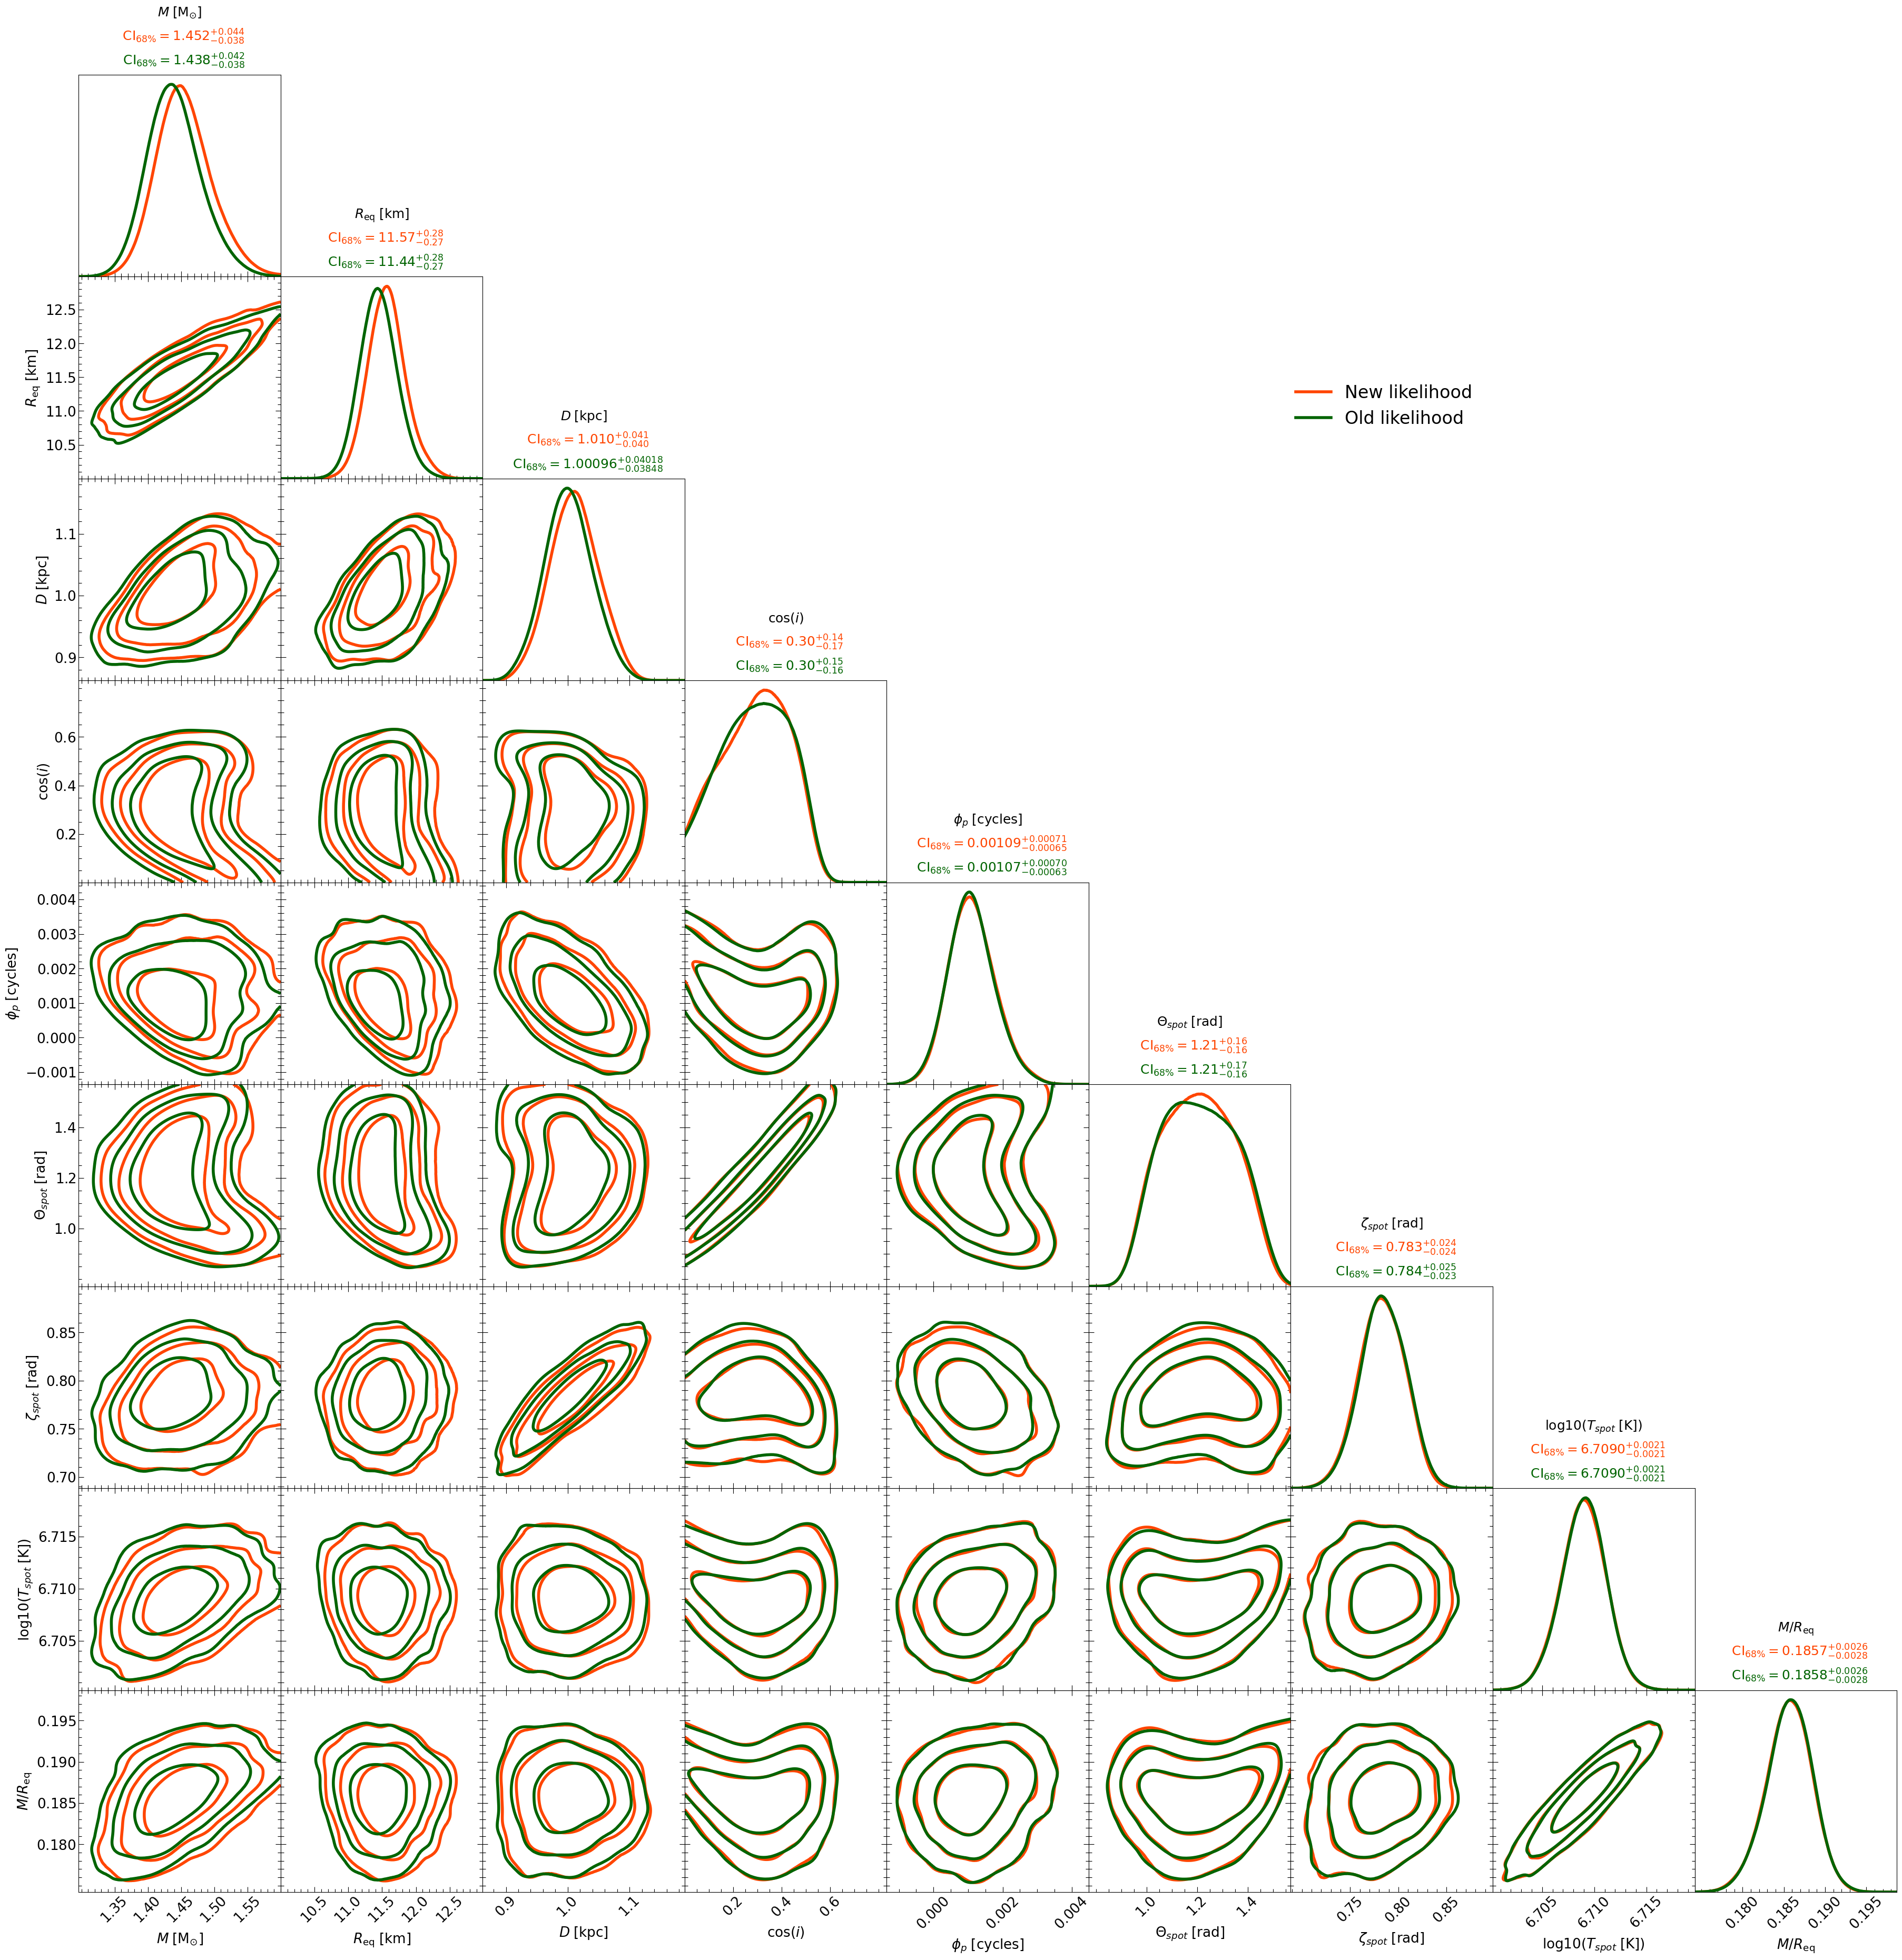

In [10]:
pp = xpsi.PostProcessing.CornerPlotter([old_model.runs, new_model.runs])

_ = pp.plot(
     params=old_model.names,#["mass","radius"],
    
     IDs=OrderedDict([('Old likelihood', ['run',]),('New likelihood', ['run',])]),
     prior_density=False,
     KL_divergence=True,
     ndraws=5e4,
     combine=False, combine_all=True, only_combined=False, overwrite_combined=True,
     param_plot_lims={},
     bootstrap_estimators=False,
     bootstrap_density=False,
     n_simulate=200,
     crosshairs=False,
     write=False,
     ext='.png',
     maxdots=3000,
     root_filename='run',
     credible_interval_1d=True,
     annotate_credible_interval=True,
     credible_interval_1d_all_show=True,
     show_vband=None,
     compute_all_intervals=False,
     sixtyeight=True,
     axis_tick_x_rotation=45.0,
     num_plot_contours=3,
     subplot_size=4.0,
     legend_corner_coords=(0.675,0.8),
     legend_frameon=False,
     scale_attrs=OrderedDict([('legend_fontsize', 2.0),
                              ('axes_labelsize', 1.35),
                              ('axes_fontsize', 'axes_labelsize'),
                             ]
                            ),
     colormap='Reds',
     shaded=False,
     shade_root_index=-1,
     rasterized_shade=True,
     no_ylabel=True,
     no_ytick=True,
     lw=4.0,
     lw_1d=4.0,
     filled=False,
     normalize=True,
     veneer=True,
     line_colors=['darkgreen', "orangered"],
     tqdm_kwargs={'disable': False},
     lengthen=2.0,
     embolden=1.0,
     nx=500)


# <center>  2. Prior Update

## In the Module folder, we made a file called main_IS_prior.py.
## The model is the same, but the only change was the prior. In the CustomPrior_IS.py file, the mass prior changed (look at the density method) to $M \sim U(1., 1.6)$ to $M \sim N(1.4, 0.01^2)$. The new mass distribution is truncated at $2.5\sigma$. The radius also changed from $R_{\mathrm{eq}} \sim U(10., 13.)$ to $R_{\mathrm{eq}} \sim N(11.5, 0.01^2)$. The new radius distribution is truncated at $1.5\sigma$.

In [11]:
%%capture
from Modules import main_IS_prior as new_model  # The prior density has changed in CustomPrior_IS compared to CustomPrior

In [12]:
# Doing importance sampling

# Commenting this as it takes a bit of time to run
######################
# importance(new_model.likelihood,
#                   old_model.likelihood,
#                   'Outputs/ST_live_1000_eff_0.3_seed42_',
#                   names = names,
#                   likelihood_change = False,
#                   prior_change = True,
#                   weight_threshold=1.0e-30,
#                   overwrite=True)

## Running the cell above will generate a file called, ST_live_1000_eff_0.3_seed42__importance_sampled_prior_change.txt
## that contains the new posteriors

## Now let's plot the new posteriors and compare them to the old ones

In [13]:
new_model.names = old_model.names
new_model.bounds = old_model.bounds
new_model.labels = old_model.labels

In [14]:
old_model.runs = xpsi.Runs.load_runs(ID='Old prior',
                               run_IDs=['run'],
                               roots=['ST_live_1000_eff_0.3_seed42'],
                               base_dirs=['Outputs/'],
                               use_nestcheck=[False],
                               kde_settings=getdist_kde_settings,
                               likelihood=old_model.likelihood,
                               names=old_model.names,
                               bounds=old_model.bounds,
                               labels=old_model.labels,
                               implementation='multinest',
                               overwrite_transformed=True)

new_model.runs = xpsi.Runs.load_runs(ID='New prior',
                               run_IDs=['run'],
                               roots=['ST_live_1000_eff_0.3_seed42_importance_sampled_prior_change'],
                               base_dirs=['Outputs/'],
                               use_nestcheck=[False],
                               kde_settings=getdist_kde_settings,
                               likelihood=new_model.likelihood,
                               names=new_model.names,
                               bounds=new_model.bounds,
                               labels=new_model.labels,
                               implementation='multinest',
                               overwrite_transformed=True)

Executing posterior density estimation...
Curating set of runs for posterior plotting...
Run set curated.
Constructing lower-triangle posterior density plot via Gaussian KDE:
plotting:  ['mass', 'radius']
plotting:  ['mass', 'distance']
plotting:  ['mass', 'cos_inclination']
plotting:  ['mass', 'p__phase_shift']
plotting:  ['mass', 'p__super_colatitude']
plotting:  ['mass', 'p__super_radius']
plotting:  ['mass', 'p__super_temperature']
plotting:  ['mass', 'compactness']
plotting:  ['radius', 'distance']
plotting:  ['radius', 'cos_inclination']
plotting:  ['radius', 'p__phase_shift']
plotting:  ['radius', 'p__super_colatitude']
plotting:  ['radius', 'p__super_radius']
plotting:  ['radius', 'p__super_temperature']
plotting:  ['radius', 'compactness']
plotting:  ['distance', 'cos_inclination']
plotting:  ['distance', 'p__phase_shift']
plotting:  ['distance', 'p__super_colatitude']
plotting:  ['distance', 'p__super_radius']
plotting:  ['distance', 'p__super_temperature']
plotting:  ['dista

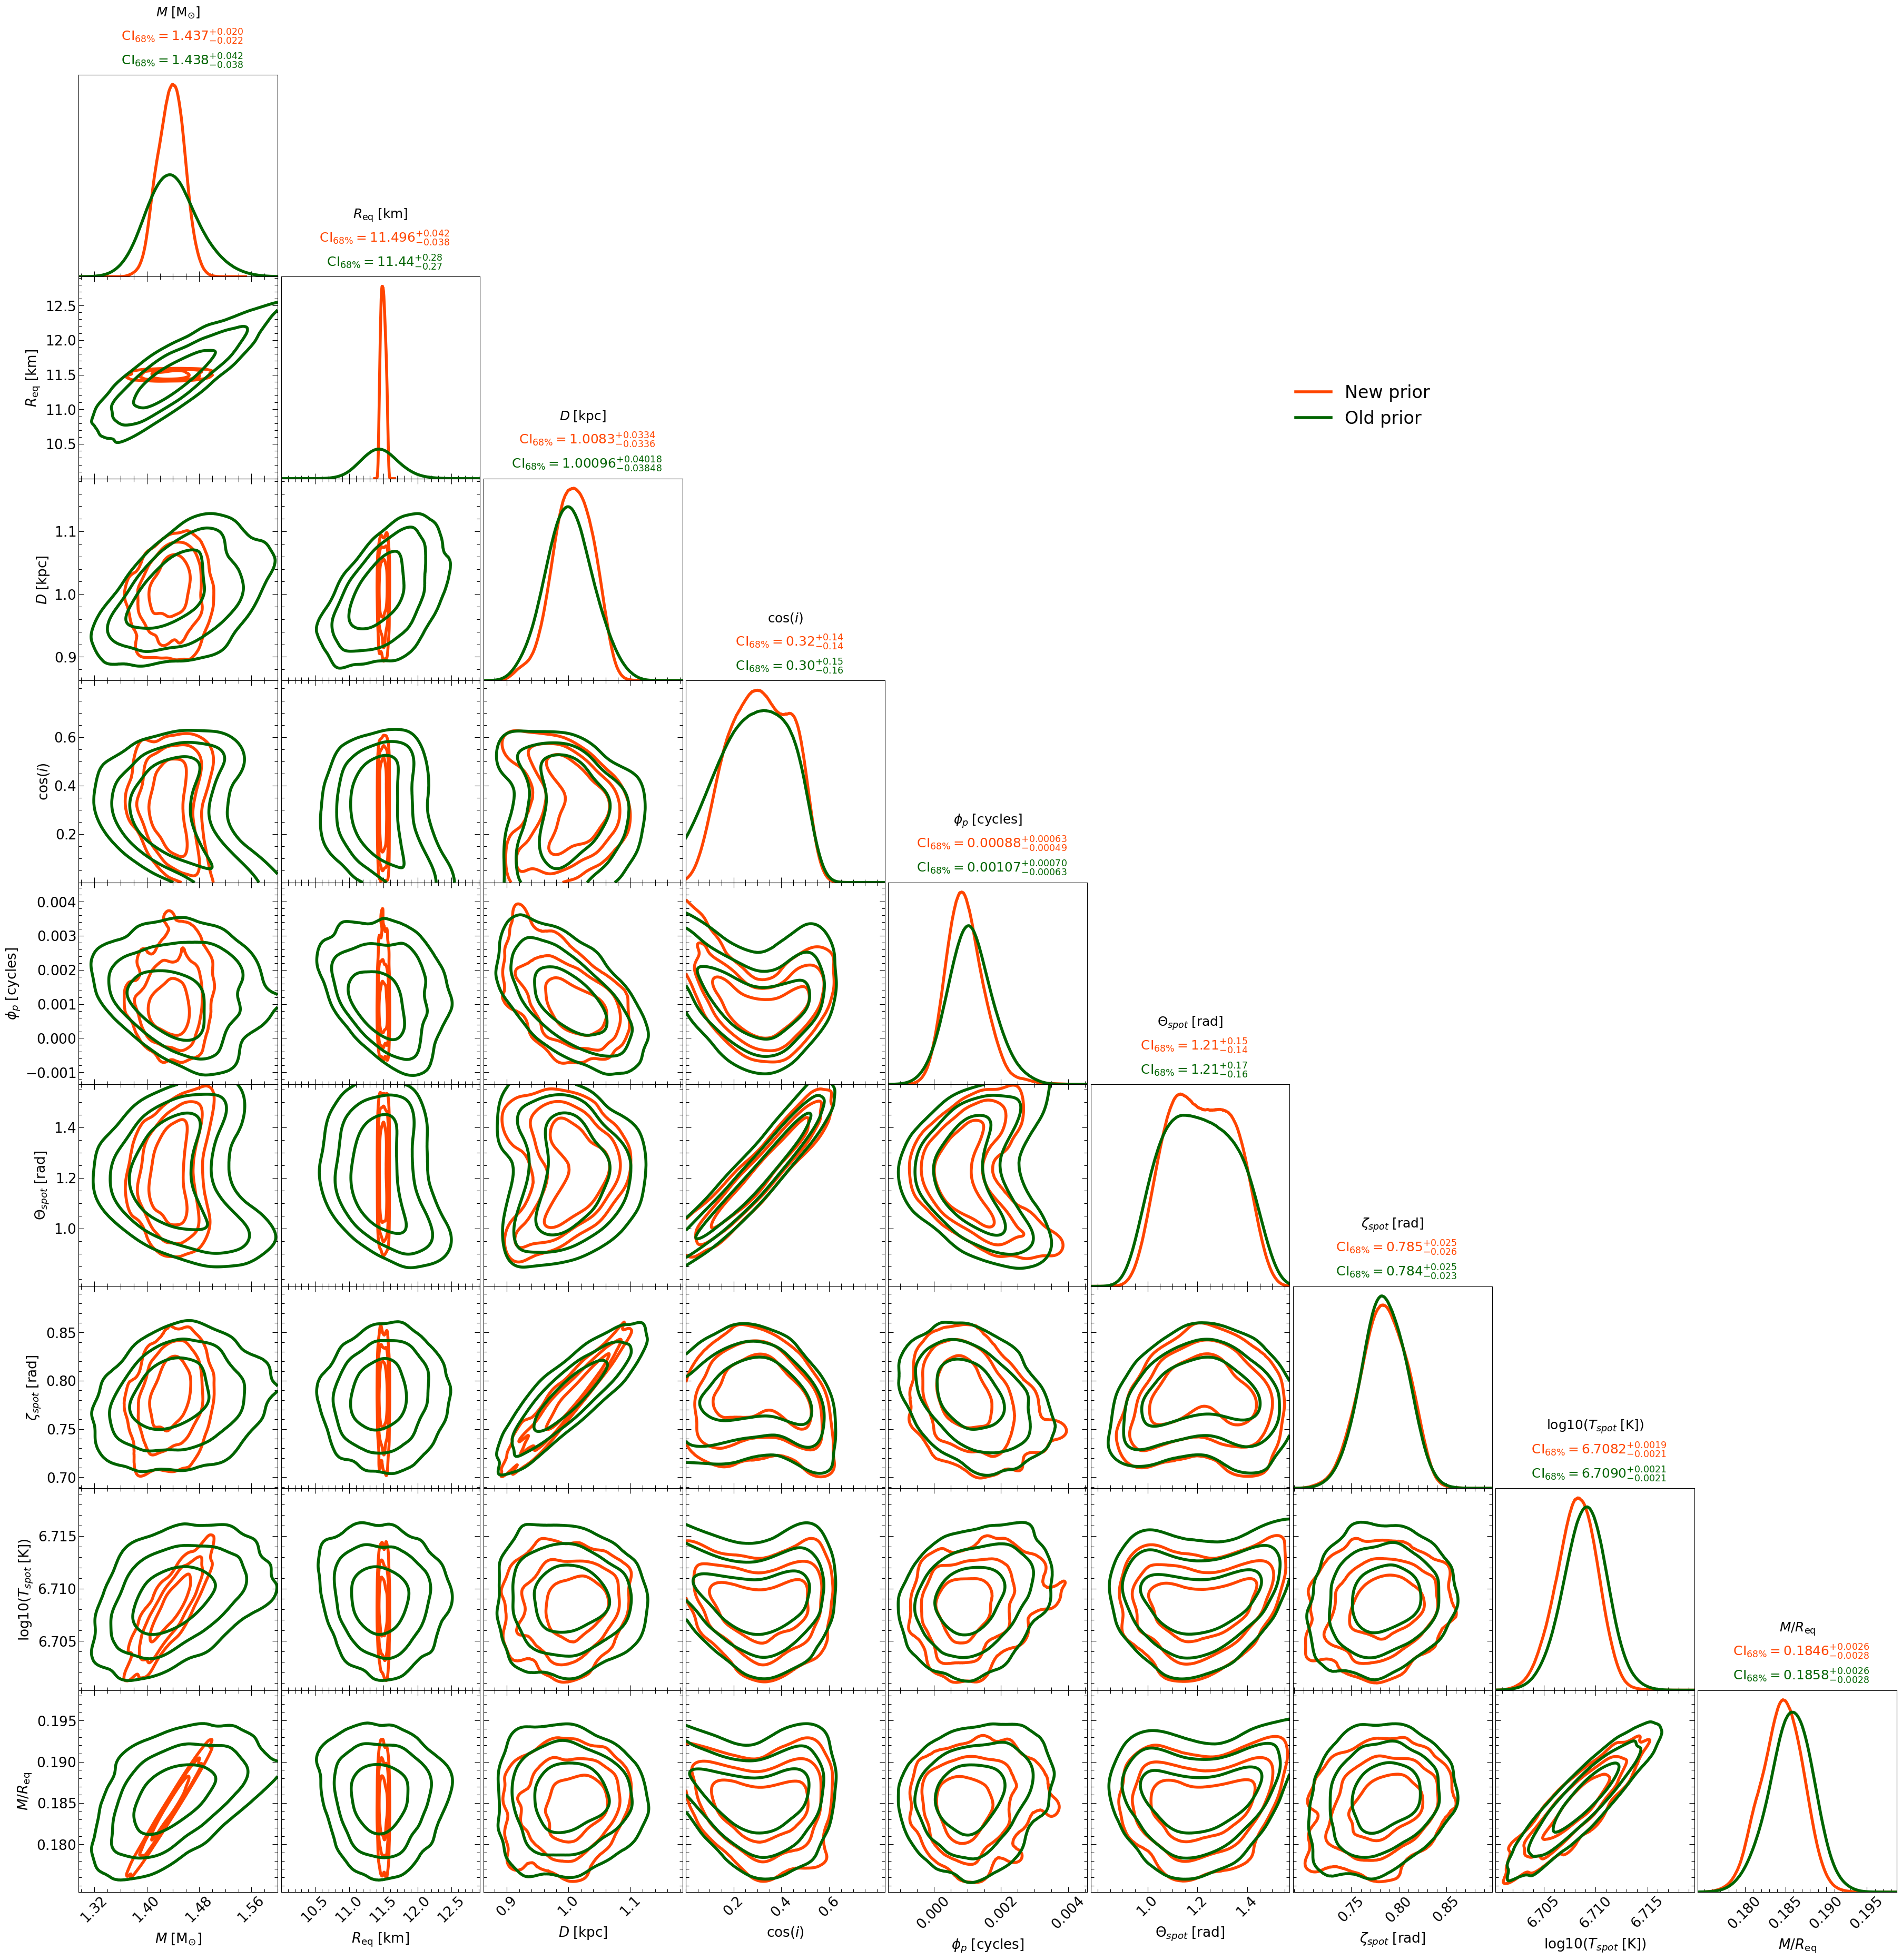

In [15]:
pp = xpsi.PostProcessing.CornerPlotter([old_model.runs, new_model.runs])

_ = pp.plot(
     params=old_model.names,#["mass","radius"],
    
     IDs=OrderedDict([('Old prior', ['run',]),('New prior', ['run',])]),
     prior_density=False,
     KL_divergence=True,
     ndraws=5e4,
     combine=False, combine_all=True, only_combined=False, overwrite_combined=True,
     param_plot_lims={},
     bootstrap_estimators=False,
     bootstrap_density=False,
     n_simulate=200,
     crosshairs=False,
     write=False,
     ext='.png',
     maxdots=3000,
     root_filename='run',
     credible_interval_1d=True,
     annotate_credible_interval=True,
     credible_interval_1d_all_show=True,
     show_vband=None,
     compute_all_intervals=False,
     sixtyeight=True,
     axis_tick_x_rotation=45.0,
     num_plot_contours=3,
     subplot_size=4.0,
     legend_corner_coords=(0.675,0.8),
     legend_frameon=False,
     scale_attrs=OrderedDict([('legend_fontsize', 2.0),
                              ('axes_labelsize', 1.35),
                              ('axes_fontsize', 'axes_labelsize'),
                             ]
                            ),
     colormap='Reds',
     shaded=False,
     shade_root_index=-1,
     rasterized_shade=True,
     no_ylabel=True,
     no_ytick=True,
     lw=4.0,
     lw_1d=4.0,
     filled=False,
     normalize=True,
     veneer=True,
     line_colors=['darkgreen', "orangered"],
     tqdm_kwargs={'disable': False},
     lengthen=2.0,
     embolden=1.0,
     nx=500)


### This is it. That's a very simple example. One can also look at xpsi/utilities/ImportanceSample.py (Good luck!)